# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720496109664e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularization loss.

In [9]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [10]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
b1 max relative error: 1.555470e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 3.865091e-11


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.02.

In [ ]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [11]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [12]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


iteration 0 / 1000: loss 2.302998
iteration 100 / 1000: loss 2.302582
iteration 200 / 1000: loss 2.296229
iteration 300 / 1000: loss 2.255391
iteration 400 / 1000: loss 2.235396
iteration 500 / 1000: loss 2.138494
iteration 600 / 1000: loss 2.091262
iteration 700 / 1000: loss 2.027867
iteration 800 / 1000: loss 2.029499
iteration 900 / 1000: loss 1.973712
Validation accuracy:  0.282


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

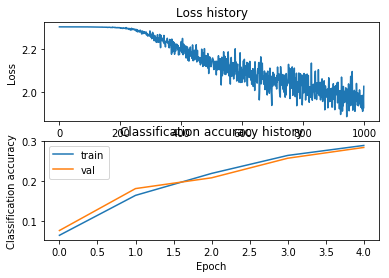

In [13]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

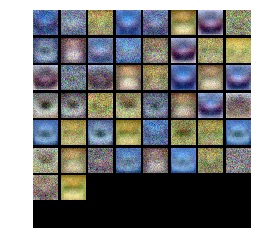

In [14]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit Your Answer:}$ 先确定哪些是hyperparameter；再按uniform的distribution的方式去按不同的范围来找哪些hyperparameter的效果好；慢慢缩小范围；最终在一个离散的范围里挑选最优的hyperparameter

In [21]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# get random hyperparameters given arrays of potential values
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden

input_size = 32 * 32 * 3
num_classes = 10
best_val = -1
best_stats = []

np.random.seed(0)
for i in range(15):
    #lr, reg, hidden_size = generate_random_hyperparams(-6, -3, -5, 5, 20, 500)
    # 上面这行发现只要reg>0, accuracy就很差
    #lr 4.430375e-05 reg 1.418710e+02 hid 343  train accuracy: 0.100265 val accuracy: 0.087000
    #lr 5.856418e-06 reg 2.639535e+02 hid 43  train accuracy: 0.100041 val accuracy: 0.098000
    #lr 1.454237e-05 reg 1.573989e-01 hid 388  train accuracy: 0.189898 val accuracy: 0.203000
    #lr 3.607495e-05 reg 7.544398e-03 hid 498  train accuracy: 0.266857 val accuracy: 0.273000
    #lr 1.022746e-05 reg 1.028432e+00 hid 116  train accuracy: 0.199633 val accuracy: 0.208000
    #lr 1.761616e-05 reg 1.263453e+01 hid 25  train accuracy: 0.164898 val accuracy: 0.183000
    #lr 1.017980e-04 reg 3.256360e+01 hid 472  train accuracy: 0.216980 val accuracy: 0.226000
    #lr 1.203365e-04 reg 1.507132e-02 hid 489  train accuracy: 0.402143 val accuracy: 0.400000
    #lr 3.703068e-06 reg 4.844024e-03 hid 452  train accuracy: 0.238796 val accuracy: 0.236000
    #lr 5.826458e-06 reg 1.017212e-03 hid 70  train accuracy: 0.223245 val accuracy: 0.243000
    #lr 5.486679e-04 reg 6.520814e-01 hid 406  train accuracy: 0.513224 val accuracy: 0.497000
    #lr 1.162013e-04 reg 4.019934e-04 hid 270  train accuracy: 0.391020 val accuracy: 0.389000
    #lr 2.803223e-04 reg 3.876119e+00 hid 226  train accuracy: 0.403612 val accuracy: 0.422000
    #lr 3.075239e-06 reg 1.698790e+04 hid 387  train accuracy: 0.100429 val accuracy: 0.079000
    #lr 6.772256e-05 reg 9.777279e-01 hid 139  train accuracy: 0.325388 val accuracy: 0.318000
    #lr 1.684244e-04 reg 3.895341e+03 hid 484  train accuracy: 0.100449 val accuracy: 0.078000
    #lr 1.740483e-06 reg 1.474949e+03 hid 341  train accuracy: 0.100429 val accuracy: 0.079000
    #lr 4.618671e-06 reg 2.426584e-03 hid 236  train accuracy: 0.211918 val accuracy: 0.234000
    #lr 2.018807e-04 reg 2.610436e-01 hid 278  train accuracy: 0.440408 val accuracy: 0.449000 这个貌似比较折中
    #lr 9.649787e-05 reg 5.162339e+01 hid 246  train accuracy: 0.161857 val accuracy: 0.177000
    
    #lr, reg, hidden_size = generate_random_hyperparams(-4, -2, -3, 0, 20, 300) 
    #发现最优时lr基本是e-03 reg是e-01这个级别
    #lr 1.252065e-03 reg 1.398196e-01 hid 271  train accuracy: 0.585327 val accuracy: 0.537000
    #lr 2.051260e-04 reg 7.476958e-03 hid 244  train accuracy: 0.444694 val accuracy: 0.462000
    #lr 3.252495e-03 reg 9.727277e-01 hid 132  train accuracy: 0.481102 val accuracy: 0.484000
    #lr 5.475240e-03 reg 4.522237e-01 hid 187  train accuracy: 0.100265 val accuracy: 0.087000
    #lr 4.483742e-04 reg 1.502408e-03 hid 224  train accuracy: 0.517980 val accuracy: 0.489000
    #lr 5.670722e-03 reg 7.042446e-01 hid 110  train accuracy: 0.100265 val accuracy: 0.087000
    #lr 5.017402e-04 reg 3.337783e-03 hid 235  train accuracy: 0.532163 val accuracy: 0.495000
    #lr 5.583459e-03 reg 3.873501e-02 hid 192  train accuracy: 0.100265 val accuracy: 0.087000
    #lr 1.271360e-03 reg 4.346647e-03 hid 60  train accuracy: 0.559184 val accuracy: 0.516000
    #lr 7.196423e-04 reg 1.746720e-01 hid 184  train accuracy: 0.543000 val accuracy: 0.492000
    
    #lr, reg, hidden_size = generate_random_hyperparams(-4, -3, -1, 0, 100, 300) 
    #lr 0.001附近较好 reg 0.1附近较好
    #lr 3.538454e-04 reg 5.190263e-01 hid 167  train accuracy: 0.478735 val accuracy: 0.468000
    #lr 7.749017e-04 reg 2.348532e-01 hid 219  train accuracy: 0.548918 val accuracy: 0.502000
    #lr 2.295676e-04 reg 1.130065e-01 hid 135  train accuracy: 0.450571 val accuracy: 0.459000
    #lr 2.945758e-04 reg 4.956711e-01 hid 253  train accuracy: 0.471000 val accuracy: 0.458000
    #lr 2.752269e-04 reg 4.049913e-01 hid 265  train accuracy: 0.465184 val accuracy: 0.463000
    #lr 1.558349e-04 reg 3.745701e-01 hid 223  train accuracy: 0.412429 val accuracy: 0.416000
    #lr 4.006343e-04 reg 7.795982e-01 hid 156  train accuracy: 0.479939 val accuracy: 0.472000
    #lr 2.808926e-04 reg 1.786931e-01 hid 220  train accuracy: 0.470837 val accuracy: 0.463000
    #lr 3.391272e-04 reg 2.665161e-01 hid 159  train accuracy: 0.484327 val accuracy: 0.467000
    #lr 3.773849e-04 reg 3.223802e-01 hid 173  train accuracy: 0.491571 val accuracy: 0.480000
    
    #lr, reg, hidden_size = random_search_hyperparams([0.001, 0.002, 0.003], [0.1, 0.2, 0.3, 0.4, 0.5], [10, 50, 100, 150, 200])
    #lr 1.000000e-03 reg 1.000000e-01 hid 150  train accuracy: 0.556367 val accuracy: 0.509000
    #lr 1.000000e-03 reg 1.000000e-01 hid 10  train accuracy: 0.426163 val accuracy: 0.417000
    #lr 1.000000e-03 reg 4.000000e-01 hid 10  train accuracy: 0.418347 val accuracy: 0.399000
    #lr 3.000000e-03 reg 1.000000e-01 hid 200  train accuracy: 0.549735 val accuracy: 0.518000
    #lr 3.000000e-03 reg 2.000000e-01 hid 100  train accuracy: 0.514265 val accuracy: 0.481000
    #lr 1.000000e-03 reg 1.000000e-01 hid 150  train accuracy: 0.564531 val accuracy: 0.490000
    #lr 2.000000e-03 reg 5.000000e-01 hid 100  train accuracy: 0.516571 val accuracy: 0.491000
    #lr 3.000000e-03 reg 1.000000e-01 hid 50  train accuracy: 0.521980 val accuracy: 0.491000
    #lr 1.000000e-03 reg 1.000000e-01 hid 100  train accuracy: 0.562286 val accuracy: 0.513000
    #lr 3.000000e-03 reg 2.000000e-01 hid 150  train accuracy: 0.496449 val accuracy: 0.436000
    
    #lr, reg, hidden_size = random_search_hyperparams([0.001], [0.1, 0.15, 0.2, 0.3], [10, 20, 30, 40 ,50, 80, 100, 150, 200])    
    #hidden 80以上 reg 0.1附近 
    #lr 1.000000e-03 reg 1.000000e-01 hid 80  train accuracy: 0.551286 val accuracy: 0.504000
    #lr 1.000000e-03 reg 3.000000e-01 hid 200  train accuracy: 0.556653 val accuracy: 0.518000
    #lr 1.000000e-03 reg 1.500000e-01 hid 30  train accuracy: 0.504531 val accuracy: 0.476000
    #lr 1.000000e-03 reg 2.000000e-01 hid 80  train accuracy: 0.548102 val accuracy: 0.503000
    #lr 1.000000e-03 reg 2.000000e-01 hid 50  train accuracy: 0.529449 val accuracy: 0.490000
    #lr 1.000000e-03 reg 1.500000e-01 hid 80  train accuracy: 0.549898 val accuracy: 0.514000
    #lr 1.000000e-03 reg 2.000000e-01 hid 20  train accuracy: 0.475878 val accuracy: 0.480000
    #lr 1.000000e-03 reg 3.000000e-01 hid 50  train accuracy: 0.526959 val accuracy: 0.502000
    #lr 1.000000e-03 reg 1.500000e-01 hid 40  train accuracy: 0.518612 val accuracy: 0.471000
    #lr 1.000000e-03 reg 1.000000e-01 hid 50  train accuracy: 0.528469 val accuracy: 0.490000
    #lr 1.000000e-03 reg 1.500000e-01 hid 200  train accuracy: 0.552714 val accuracy: 0.515000
    #lr 1.000000e-03 reg 1.000000e-01 hid 80  train accuracy: 0.553327 val accuracy: 0.518000
    #lr 1.000000e-03 reg 3.000000e-01 hid 40  train accuracy: 0.513939 val accuracy: 0.481000
    #lr 1.000000e-03 reg 3.000000e-01 hid 50  train accuracy: 0.515735 val accuracy: 0.486000
    #lr 1.000000e-03 reg 1.000000e-01 hid 150  train accuracy: 0.570837 val accuracy: 0.527000
    
    lr, reg, hidden_size = random_search_hyperparams([0.001], [0.05, 0.1, 0.15], [80, 100, 150, 200])    
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    
    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train) == y_train).mean()
    
    # Predict on the validation set
    val_accuracy = (net.predict(X_val) == y_val).mean()
    
    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr 1.000000e-03 reg 5.000000e-02 hid 200  train accuracy: 0.574082 val accuracy: 0.508000
lr 1.000000e-03 reg 1.500000e-01 hid 100  train accuracy: 0.546490 val accuracy: 0.494000
lr 1.000000e-03 reg 1.000000e-01 hid 80  train accuracy: 0.537367 val accuracy: 0.485000
lr 1.000000e-03 reg 1.000000e-01 hid 150  train accuracy: 0.569429 val accuracy: 0.532000
lr 1.000000e-03 reg 1.500000e-01 hid 80  train accuracy: 0.543000 val accuracy: 0.503000
lr 1.000000e-03 reg 5.000000e-02 hid 150  train accuracy: 0.572122 val accuracy: 0.518000
lr 1.000000e-03 reg 1.000000e-01 hid 150  train accuracy: 0.569184 val accuracy: 0.519000
lr 1.000000e-03 reg 5.000000e-02 hid 100  train accuracy: 0.563224 val accuracy: 0.519000
lr 1.000000e-03 reg 5.000000e-02 hid 200  train accuracy: 0.578367 val accuracy: 0.529000
lr 1.000000e-03 reg 1.500000e-01 hid 100  train accuracy: 0.553980 val accuracy: 0.497000
lr 1.000000e-03 reg 1.500000e-01 hid 200  train accuracy: 0.553143 val accuracy: 0.514000
lr 1.000000e

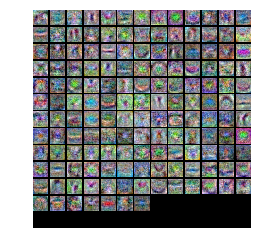

In [22]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [23]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.514


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$ 1 and 3

$\color{blue}{\textit Your Explanation:}$ 因为overfitting了；增加训练数据和通过增加regularization strength去惩罚W的复杂度可以降低overfitting

